In [7]:
import numpy as np
import os
import matplotlib.pyplot as plt
import sys
import cv2
sys.path.insert(0, '../codes')
import video_utils
from skimage.measure import compare_ssim as ssim
from calibrate_videos2 import compute_cam_params

In [2]:
# the notebook will reload external python modules;
%load_ext autoreload
%autoreload 2

In [3]:
#make matplotlib figures appear inline in the notebook
#rather than in a new window.
%matplotlib inline
#sns.set()
# set default size of plots
plt.rcParams['figure.figsize'] = (12.0, 10.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20


#print OpenCV version
print ("OpenCV Version : %s " % cv2.__version__)

OpenCV Version : 3.4.3 


In [4]:
def mse(x, y):
    return np.linalg.norm(x - y)/(x.shape[0]*x.shape[1])

## Detecting keypoints and computing cam params

In [5]:
videos_path = '../data/DJI4_cam/2018-09-05/seq001/calibration'
video_name = 'calibration.MOV'
video = os.path.join(videos_path, video_name)

In [9]:
vid = video_utils.videoObj(videopath=video)
# ret, mtx, dist, rvecs, tvecs = vid.cam_params(frame_step=20)
cam_params = compute_cam_params(video)

Detecting keypoint in video: ../data/DJI4_cam/2018-09-05/seq001/calibration/calibration.MOV...


HBox(children=(IntProgress(value=0, max=555), HTML(value='')))


Number of pattern found:  25
computing cam params...
Done!


In [12]:
print('rms: {}'.format(cam_params['ret']))
print('camera matrix: \n', cam_params['mtx'])
print('distortion coefficients: ', cam_params['dist'])
print('new camera matrix: \n', cam_params['newcameramtx'])

rms: 1.7126577960269953
camera matrix: 
 [[2.61803547e+03 0.00000000e+00 1.91749119e+03]
 [0.00000000e+00 2.61005888e+03 1.10197354e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
distortion coefficients:  [[ 0.01213659 -0.16437349  0.00267507 -0.00277549  0.23259577]]
new camera matrix: 
 [[2.61519409e+03 0.00000000e+00 1.91350417e+03]
 [0.00000000e+00 2.74894800e+03 1.17091118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


## Testing calibration

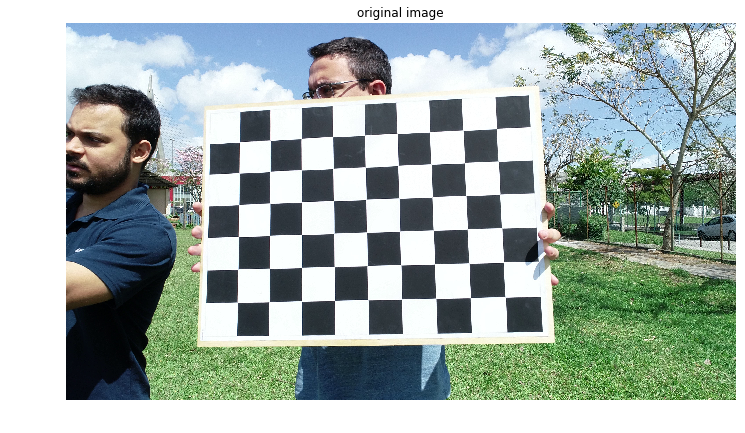

image size:  (2160, 3840, 3)


In [13]:
#load video
video_test = os.path.join(videos_path,video_name)
video_capture = cv2.VideoCapture(video_test)

#extract first frame
success,img = video_capture.read()
h, w = img.shape[:2]

#displaying image
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('original image')
plt.show()
print('image size: ', img.shape)

* optimizing camera params:

In [21]:
#optimize camera matrix
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(cam_params['mtx'], cam_params['dist'], (w,h), 0, (w,h))

print('\nCamera matrix: \n', cam_params['mtx'])
print('\nNew camera matrix: \n', newcameramtx)
print('\nRoI: \n', roi)


Camera matrix: 
 [[2.61803547e+03 0.00000000e+00 1.91749119e+03]
 [0.00000000e+00 2.61005888e+03 1.10197354e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

New camera matrix: 
 [[2.64024878e+03 0.00000000e+00 1.90665840e+03]
 [0.00000000e+00 2.63737109e+03 1.10790694e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

RoI: 
 (0, 0, 3840, 2160)


* undistorting frame:

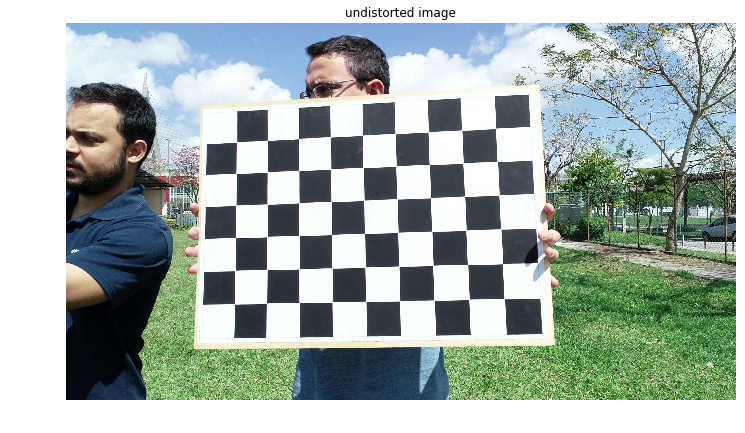

image size:  (2160, 3840, 3)


In [22]:
#undistort
dst = cv2.undistort(img, cam_params['mtx'], cam_params['dist'], None, newcameramtx)

plt.imshow(cv2.cvtColor(dst,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('undistorted image')
plt.show()
print('image size: ', dst.shape)

* computing SSIM and MSE between images...

In [11]:
MSE = mse(img, dst)
SSIM = ssim(img, dst, multichannel=True)

print('MSE: ', MSE)
print('SSIM: ', SSIM)

MSE:  0.0925225173059181
SSIM:  0.5094579881698112


* blending original and undistorted images...

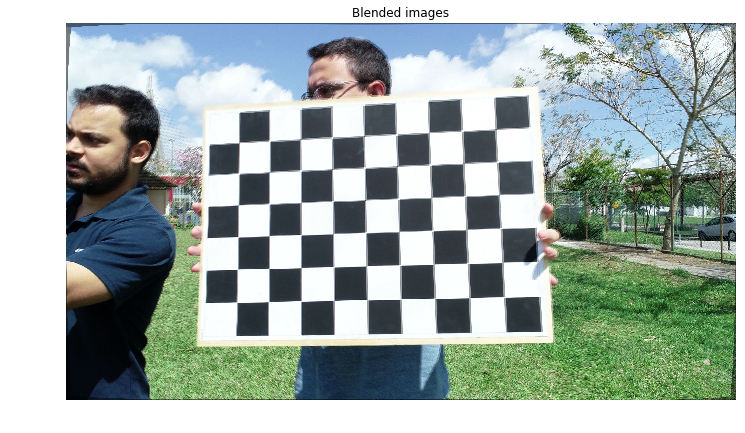

In [12]:
alpha = 0.5
beta = (1.0 - alpha)
blend = np.uint8(alpha*(img)+beta*(dst))

plt.imshow(cv2.cvtColor(blend,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Blended images')
plt.show()